# Exercise 2: Neural network
The basic center of mass tracking method that we used in the [vision tutorial](1_vision.ipynb) might fail for objects that blend in closely with the background. In this exercise, we will introduce a second fly into the arena and deploy a neural network to accurately track its location.

For the neural network to learn, it's essential to first compile a dataset containing images along with the precise locations of this additional fly. This has been implemented in [collect_data.py](collect_data.py). The script requires a few minutes to execute. To speed up the process, the dataset have already been generated and saved in [data/data.npz](data/data.npz).

Now, we will proceed to load the dataset:

Shape of images: (10000, 2, 16, 31)


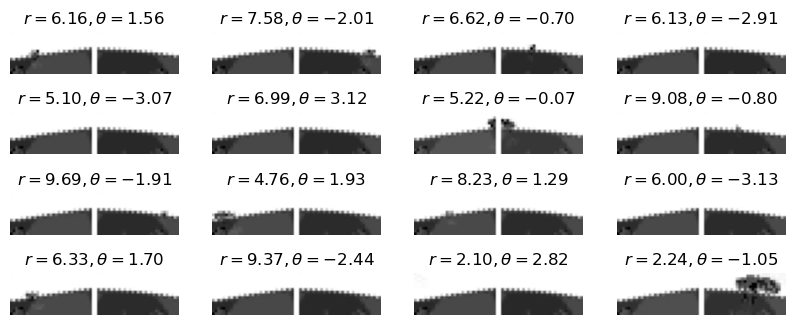

In [1]:
import matplotlib.pyplot as plt
import numpy as np

data = np.load("data/data.npz")
images = data["images"]
# The images are stored in a 4D array (n_images, n_eyes, n_rows, n_cols)
print(f"Shape of images: {images.shape}")
# The positions of the second fly are stored in polar coordinates (r, theta)
r = data["r"]
theta = data["theta"]
data.close()

# display the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(10, 4))
bar = np.ones((images.shape[-2], 2))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.concatenate([images[i, 0], bar, images[i, 1]], axis=-1), cmap="gray")
    ax.set_title(f"$r={r[i]:.2f}, \\theta={theta[i]:.2f}$")
    ax.axis("off")

We will convert the position of the fly from polar coordinates $(r, \theta)$ into a Cartesian coordinate system that has undergone rotation and inversion. The two basis vectors point at 45° to the left and right of the fly, respectively.

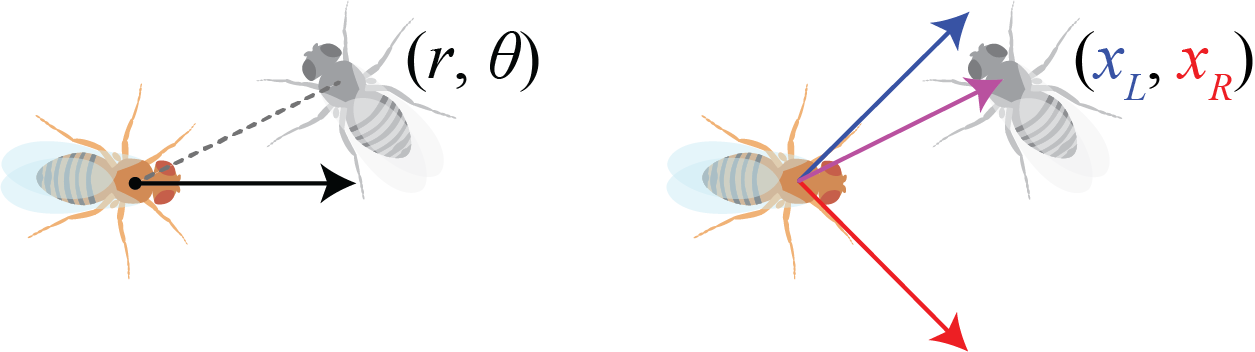

Implement the conversion below. What is the advantage of this encoding?

In [2]:
################################################################
# TODO: Convert the polar coordinates to cartesian coordinates
coords_lr = r * np.exp(1j * (np.pi / 4 - theta))
coords_lr = np.column_stack([coords_lr.real, coords_lr.imag])
################################################################

# The shape should be (# of samples, 2)
assert coords_lr.shape == (len(images), 2)

Next, we can create the data loaders:

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(torch.tensor(images), torch.tensor(coords_lr))
datasets = dict(
    zip(["train", "val", "test"], random_split(dataset, [0.8, 0.1, 0.1]))
)
batch_size = 32
loaders = {
    name: DataLoader(dataset, batch_size=batch_size, shuffle=name == "train")
    for name, dataset in datasets.items()
}

Construct your neural network model in the following cell. A simple Convolutional Neural Network (CNN) should be enough for achieving good performance on this dataset. For how to construct a CNN, you can refer to the PyTorch official tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [4]:
from torch import nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #########################################
        # TODO: Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)
        self.fc1 = nn.LazyLinear(16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        #########################################

    def forward(self, x):
        #########################################
        # TODO: Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.tanh(self.conv3(x))
        x = x.max(-2)[0]
        x = x.flatten(1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
        #########################################

In [5]:
from copy import deepcopy
import torch.optim as optim

model = Model()
model.to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float("inf")

for epoch in range(100):
    model.train()

    train_loss = 0

    for inputs, labels in loaders["train"]:
        optimizer.zero_grad()
        outputs = model(inputs.to("cuda"))
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loaders["train"])

    model.eval()

    with torch.no_grad():
        val_loss = 0
        for inputs, labels in loaders["val"]:
            outputs = model(inputs.to("cuda"))
            val_loss += criterion(outputs, labels.to("cuda")).item()

    val_loss /= len(loaders["val"])

    print(f"{epoch=}, {train_loss=:0.4f}, {val_loss=:0.4f}")

    if val_loss < best_val_loss:
        best_model_state = deepcopy(model.state_dict())
        best_val_loss = val_loss

model.load_state_dict(best_model_state)

epoch=0, train_loss=19.1511, val_loss=15.0072
epoch=1, train_loss=9.1089, val_loss=6.2376
epoch=2, train_loss=5.4791, val_loss=5.5227
epoch=3, train_loss=4.8455, val_loss=5.6471
epoch=4, train_loss=4.6175, val_loss=4.5887
epoch=5, train_loss=4.4662, val_loss=4.4911
epoch=6, train_loss=4.3860, val_loss=4.3639
epoch=7, train_loss=4.3410, val_loss=4.2970
epoch=8, train_loss=4.1846, val_loss=4.2693
epoch=9, train_loss=4.2125, val_loss=4.3089
epoch=10, train_loss=4.0863, val_loss=4.2328
epoch=11, train_loss=4.0554, val_loss=4.2268
epoch=12, train_loss=4.1227, val_loss=4.1081
epoch=13, train_loss=4.0227, val_loss=4.4890
epoch=14, train_loss=3.9737, val_loss=4.0706
epoch=15, train_loss=3.9332, val_loss=4.0992
epoch=16, train_loss=3.8810, val_loss=4.0928
epoch=17, train_loss=3.8177, val_loss=4.1798
epoch=18, train_loss=3.7851, val_loss=3.8677
epoch=19, train_loss=3.6864, val_loss=3.8286
epoch=20, train_loss=3.5875, val_loss=3.6773
epoch=21, train_loss=3.5446, val_loss=3.6637
epoch=22, train_lo

<All keys matched successfully>

Let's visualize the performance of the model.

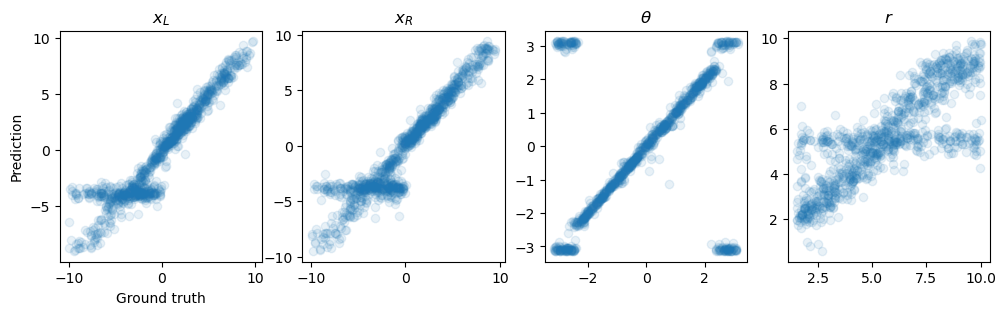

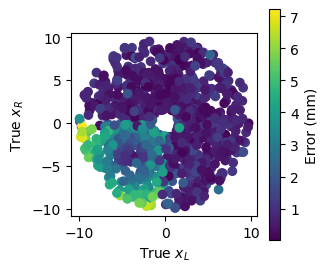

In [6]:
test_indices = datasets["test"].indices

with torch.no_grad():
    coords_lr_pred = model(torch.tensor(images[test_indices]).cuda()).cpu().numpy()

################################################################
# TODO: Convert the predicted cartesian coordinates to
# polar coordinates
theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
r_pred = np.abs(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
################################################################
assert theta_pred.shape == (len(test_indices),)
assert r_pred.shape == (len(test_indices),)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))

for i in range(2):
    axs[i].scatter(coords_lr[test_indices, i], coords_lr_pred[:, i], alpha=0.1)

axs[2].scatter(theta[test_indices], theta_pred, alpha=0.1)
axs[3].scatter(r[test_indices], r_pred, alpha=0.1)
axs[0].set_ylabel("Prediction")
axs[0].set_xlabel("Ground truth")

for ax, title in zip(axs, ["$x_L$", "$x_R$", "$\\theta$", "$r$"]):
    ax.set_title(title)

################################################################
# TODO: Calculate the distance between the true and predicted
# coordinates
distance = np.linalg.norm(coords_lr[test_indices] - coords_lr_pred, axis=1)
################################################################
assert np.shape(distance) == (len(test_indices),)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(*coords_lr[test_indices].T, c=distance)
ax.set_xlabel("True $x_L$")
ax.set_ylabel("True $x_R$")
ax.set_aspect("equal")
fig.colorbar(ax.collections[0], ax=ax, label="Error (mm)")

Is there a range of inputs for which the model does not perform well? If so, what does that range represent?

In this exercise, we have learned how to
- Create image datasets with NeuroMechFly simulation
- Use neural networks to estimate object position